# 频繁模式和关联规则挖掘
github远程仓库地址：[GitHub - clock2125/datamining_hw2](https://github.com/clock2125/datamining_hw2.git)

本次实验选用的数据集为Wine Reviews数据集，该数据集中记录了各个酒庄生产的各种葡萄酒的信息，该数据集主要有以下的属性：
- country：葡萄酒的生产国
- description：品酒师对该酒的描述
- designation：酿造使用的葡萄来自的葡萄园名称
- points：WineEnthusiast对葡萄酒的评分
- price：一瓶酒的价格
- province：酒的生产省份
- region_1：酒的生产地
- region_2：更详细的生产地
- taster_name：品酒师的名字
- taster_twitter_handle：品酒师推特账号
- title：葡萄酒评论的标题
- variety：生产所用葡萄的品种
- winery：酒厂名

## 导入数据

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

df_data = pd.read_csv('datasets/winemag-data-130k-v2.csv') # 读取数据 
print(df_data.head(5)) # 查看前五行 

   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0              

## 数据处理
title包含生产地、葡萄收获期等信息，重复度较高，而taster_twitter_handle品酒师推特账号和品酒师名字高度重复，因此删去这两列减少数据量。同时为数据集填补缺失值。

In [6]:
from sklearn.impute import SimpleImputer

# 删去无用的列
df_data = df_data.drop(['Unnamed: 0', 'title', 'taster_twitter_handle'], axis=1)

# 用region_1的值来填充region_2的缺失值
df_data['region_2'].fillna(value=df_data['region_1'], inplace=True)

# 使用最高频率值来填补缺失值
simpleImp = SimpleImputer(strategy="most_frequent")
data_columns = df_data.columns
df_nona = pd.DataFrame(simpleImp.fit_transform(df_data))
df_nona.columns = data_columns

对于points和price这两个数值属性，要进行离散化处理以便频繁模式挖掘，将points划分成长度为4的区间，每种葡萄酒用其points所在的区间代替原来的points。price也作相同的处理。

In [7]:
# 离散化points属性
for index, value in df_nona['points'].items():
    if 80 <= value < 84:
        df_nona['points'].at[index] = '80-84pts'
    elif 84 <= value < 88:
        df_nona['points'].at[index] = '84-88pts'
    elif 88 <= value < 92:
        df_nona['points'].at[index] = '88-92pts'
    elif 92 <= value < 96:
        df_nona['points'].at[index] = '92-96pts'
    elif 96 <= value:
        df_nona['points'].at[index] = '96-100pts'

#离散化price属性
for index, value in df_nona['price'].items():
    if 0 <= value < 10:
        df_nona['price'].at[index] = '0-10$'
    elif 10 <= value < 20:
        df_nona['price'].at[index] = '10-20$'
    elif 20 <= value < 30:
        df_nona['price'].at[index] = '20-30$'
    elif 30 <= value < 40:
        df_nona['price'].at[index] = '30-40$'
    elif 40 <= value < 50:
        df_nona['price'].at[index] = '40-50$'
    elif 50 <= value < 60:
        df_nona['price'].at[index] = '50-60$'
    elif 60 <= value < 70:
        df_nona['price'].at[index] = '60-70$'
    elif 70 <= value < 80:
        df_nona['price'].at[index] = '70-80$'
    elif 80 <= value < 90:
        df_nona['price'].at[index] = '80-90$'
    elif 90 <= value < 100:
        df_nona['price'].at[index] = '90-100$'
    elif 100 <= value < 150:
        df_nona['price'].at[index] = '100-150$'
    elif 150 <= value < 200:
        df_nona['price'].at[index] = '150-200$'
    elif 200 <= value < 500:
        df_nona['price'].at[index] = '200-500$'
    elif 500 <= value < 1000:
        df_nona['price'].at[index] = '500-1000$'
    elif 1000 <= value < 2000:
        df_nona['price'].at[index] = '1000-2000$'
    elif 2000 <= value:
        df_nona['price'].at[index] = '2000-$'


接下来需要把数据转换为list，其中description属性是品酒师对于葡萄酒的几句话的描述（如"Aromas of mature black-skinned berry, tobacco and dark spice lead the way. The rounded palate offers dried cherry, raspberry, coffee and a licorice note alongside velvety if not very persistent tannins. Showing the heat of the vintage, this is evolving quickly so enjoy over the next several years."），本实验中对description进行了分词，将它分割成了一个个单词，并去除其中的停用词，有助于发现品酒师的用词与其他属性的关联规则。

In [24]:
import re

# 将dataFrame转换为list
data = df_nona.to_dict('split')['data']

# 停用词表
stop_words = ['is', 'and', 'the', 'a', 'an', 'this', 'description:', 'to', 'with', 'of', 'in', 'wine', 'on', 'that', 'by', 'are', 'from', 'it\'s', 'it',
              'Is', 'And', 'The', 'A', 'An', 'This', 'Description:', 'To', 'With', 'Of', 'In', 'Wine', 'On', 'That', 'By', 'Are', 'From', 'It\'s', 'It',
              'I']

for row in data:
    for i in range(len(data_columns)):
        if i != 1:
            row[i] = data_columns[i] + ': ' + row[i]
    description = row.pop(1)
    
    # 分词
    words = re.split(r"\b[\.,\s\n\r\n]+?\b", description)

    # 去停用词
    for word in words:
        if word not in stop_words:
            row.append('word: '+word)

for i in range(5):
    print(data[i])

['country: Italy', 'designation: Vulkà Bianco', 'points: 84-88pts', 'price: 20-30$', 'province: Sicily & Sardinia', 'region_1: Etna', 'region_2: Etna', 'taster_name: Kerin O’Keefe', 'variety: White Blend', 'winery: Nicosia', 'word: Aromas', 'word: include', 'word: tropical', 'word: fruit', 'word: broom', 'word: brimstone', 'word: dried', 'word: herb', 'word: palate', "word: isn't", 'word: overly', 'word: expressive', 'word: offering', 'word: unripened', 'word: apple', 'word: citrus', 'word: dried', 'word: sage', 'word: alongside', 'word: brisk', 'word: acidity.']
['country: Portugal', 'designation: Avidagos', 'points: 84-88pts', 'price: 10-20$', 'province: Douro', 'region_1: Napa Valley', 'region_2: Central Coast', 'taster_name: Roger Voss', 'variety: Portuguese Red', 'winery: Quinta dos Avidagos', 'word: ripe', 'word: fruity', 'word: smooth', 'word: while', 'word: still', 'word: structured', 'word: Firm', 'word: tannins', 'word: filled', 'word: out', 'word: juicy', 'word: red', 'word:

## 频繁模式和关联规则挖掘
使用apriori算法找出频繁模式以及置信度高于0.6的关联规则

In [25]:
from apyori import apriori

res = apriori(transactions=data, min_confidence=0.6)
for rule in res:
    print(str(rule))

RelationRecord(items=frozenset({'country: France', 'taster_name: Roger Voss'}), support=0.14516315178001246, ordered_statistics=[OrderedStatistic(items_base=frozenset({'country: France'}), items_add=frozenset({'taster_name: Roger Voss'}), confidence=0.853980898927262, lift=2.144455956846771)])
RelationRecord(items=frozenset({'country: US', 'province: California'}), support=0.27937001331066164, ordered_statistics=[OrderedStatistic(items_base=frozenset({'country: US'}), items_add=frozenset({'province: California'}), confidence=0.665420492238899, lift=2.3818608316381695), OrderedStatistic(items_base=frozenset({'province: California'}), items_add=frozenset({'country: US'}), confidence=1.0, lift=2.3818608316381695)])
RelationRecord(items=frozenset({'region_1: Napa Valley', 'region_2: Central Coast'}), support=0.1634749290226281, ordered_statistics=[OrderedStatistic(items_base=frozenset({'region_1: Napa Valley'}), items_add=frozenset({'region_2: Central Coast'}), confidence=0.825863878415672

其中每条关联规则后给出了关联规则的lift指标，下面以关联规则france => Roger Voss(0.145163, 0.853981)为例计算其卡方指标$\chi^2$

In [21]:
num_France = df_nona['country'].value_counts().at['France']
num_Roger = df_nona['taster_name'].value_counts().at['Roger Voss']
num_total = df_nona.shape[0]

expect_num = int(num_France*num_Roger/num_total)
# print(expect_num)
observed_num = int(0.14516315178001246*num_total)
# print(observed_num)

chi_square = (expect_num - observed_num)*(expect_num - observed_num) / expect_num
print(chi_square)

11523.614571493521


## 结果分析
从上述的关联规则中可以得到以下信息：
1. 法国的葡萄酒有85%都是Roger Voss品尝的。
2. 对葡萄酒的描述中有61%的"has"都是Roger Voss说的，可能Roger Voss描述葡萄酒时的用词风格是喜欢用has
3. Roger Voss品尝的美国酒中有95%都是加州产的，可能Roger Voss这位品酒师更钟爱加州的美国酒
4. 此外通过此次关联规则挖掘还发现，葡萄酒的价格与其得分没有必然联系。

## 可视化展示

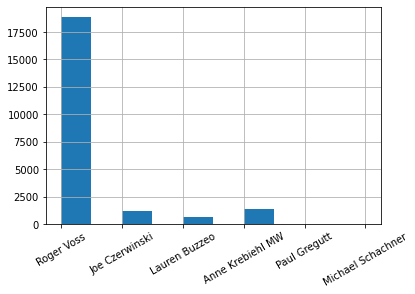

In [28]:
# 所有法国酒的品尝师分布直方图
fig, ax = plt.subplots()
df_France_taster = df_nona.loc[df_nona['country'] == 'France', ['taster_name']]
df_France_taster['taster_name'].hist(xrot=30, ax=ax, bins=10)

plt.show()

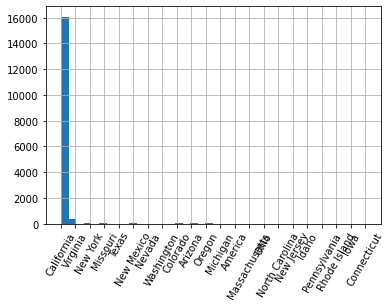

In [29]:
# Roger Voss品尝的美国酒来自各地区的直方图
fig, ax = plt.subplots()
df_US_Roger_prov = df_nona.loc[df_nona['country'] == 'US'].loc[df_nona['taster_name'] == 'Roger Voss', ['province']]
df_US_Roger_prov['province'].hist(xrot=60, ax=ax, bins=40)

plt.show()